<a href="https://colab.research.google.com/github/Madhurika1292/Medicines-and-Common-Treatment-Recommendation-System/blob/main/MRS_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medicine Recommendation System

## Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated", DeprecationWarning)

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

## Data Loading

In [2]:
# Importing dataset from drive
from google.colab import drive
drive.mount('/content/gdrive/')

import sys
sys.path.append('/content/gdrive/My Drive/Drugscom')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!ls gdrive/MyDrive/Drugscom/

Drugscom_test.csv     Drugscom_train.csv
drugsComTest_raw.csv  drugsComTrain_raw.csv


In [4]:
#Loading data
Drugscom_train=pd.read_csv('/content/gdrive/My Drive/Drugscom/Drugscom_train.csv')
Drugscom_test=pd.read_csv('/content/gdrive/My Drive/Drugscom/Drugscom_test.csv')

In [5]:
#Before
# checking for null values
Drugscom_train.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    6
dtype: int64

In [6]:
# checking for null values
Drugscom_test.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    2
dtype: int64

In [7]:
# Dropping null values
Drugscom_train = Drugscom_train.dropna(axis=0)
Drugscom_test = Drugscom_test.dropna(axis=0)

In [8]:
# checking for null values
Drugscom_train.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    0
dtype: int64

In [9]:
# checking for null values
Drugscom_test.isnull().sum()

Unnamed: 0      0
uniqueId        0
drugName        0
condition       0
review          0
rating          0
date            0
usefulCount     0
treatments      0
clean_review    0
dtype: int64

In [10]:
#Changing the "Unnamed: 0" column to uniqueId as it represents the unique id of the drugs
Drugscom_train=Drugscom_train.drop('Unnamed: 0', axis='columns')
Drugscom_test=Drugscom_test.drop('Unnamed: 0', axis='columns')

In [11]:
Drugscom_train=Drugscom_train.drop(Drugscom_train[(Drugscom_train['rating'] > 4.0) & (Drugscom_train['rating'] < 6.0)].index)
Drugscom_test=Drugscom_test.drop(Drugscom_test[(Drugscom_test['rating'] > 4.0) & (Drugscom_test['rating'] < 6.0)].index)

In [12]:
Drugscom_train['sentiment'] = np.where(Drugscom_train['rating'] >= 7, 1, 0)
Drugscom_test['sentiment'] = np.where(Drugscom_test['rating'] >= 7, 1, 0)

In [13]:
Drugscom_train.head()

,uniqueId,drugName,condition,review,rating,date,usefulCount,treatments,clean_review,sentiment
0,131173,A / B Otic,Otitis Media,"""It numbs the pain. It makes my ear feel heavi...",10,2009-09-23,20,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",numb pain make ear feel heavier least throb su...,1
1,153899,Amoxicillin,Otitis Media,"""Perforation in my right tympanic membrane (ea...",8,2011-04-12,16,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",perfor right tympan membran eardrum linger upp...,1
2,153715,Amoxicillin,Otitis Media,"""This medication did not clear up the infectio...",2,2017-05-31,0,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",medic not clear infect well notic odorless dis...,0
3,153780,Amoxicillin,Otitis Media,"""My son who was 7 months old at the time was p...",1,2016-12-09,0,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",son month old time prescrib amoxicillin ear in...,0
4,153838,Amoxicillin,Otitis Media,"""This medication works amazingly for ear infec...",9,2013-10-02,12,"ANALGESICS,ANTIBIOTIC THERAPY,Tympanostomy Tub...",medic work amaz ear infect ear infect count li...,1


In [14]:
Drugscom_train.sentiment.value_counts(normalize=True)

1    0.696646
0    0.303354
Name: sentiment, dtype: float64

In [15]:
def specific_condition_data(df,condition):
  
  return df[df['condition']==condition]

## Splitting data

In [16]:
training_data=specific_condition_data(Drugscom_train,'Acne')
testing_data=specific_condition_data(Drugscom_test,'Acne')

In [17]:
X_train=training_data.clean_review
y_train=training_data.sentiment
X_test=testing_data.clean_review
y_test=testing_data.sentiment

In [18]:
cv = CountVectorizer(max_features = 20000, ngram_range = (4, 4))

In [19]:
X_train_cv=cv.fit_transform(X_train)
X_test_cv=cv.transform(X_test)

## Model creation

### Logistic regression,  Multinomial Naive Bayes, Bernoulli Naive Bayes

In [20]:
def grid_best_parameter(X_train_cv,y_train,X_test_cv,y_test):

  # creating pipeline
  pipe_lr=Pipeline([('clf' , LogisticRegression(random_state=42))])
  pipe_mnb=Pipeline([('clf', MultinomialNB())])
  pipe_bnb=Pipeline([('clf', BernoulliNB())])


  #creating parameter

  #C= [1.0, 0.5, 0.1]
  C=np.logspace(-50, 50, 100)
  alpha= [0.01, 0.1, 0.5, 1.0, 10.0]

  param_lr =[{'clf__penalty': ['l1', 'l2'],
		          'clf__C': C,
		          'clf__solver': ['liblinear','lbfgs']}] 

  param_mnb=[{'clf__alpha': alpha}]

  param_bnb=[{'clf__alpha': alpha}]

  # creating gridsearch

  grid_lr=GridSearchCV(estimator=pipe_lr,param_grid=param_lr,scoring='accuracy',cv=10,n_jobs=-1)
  grid_mnb=GridSearchCV(estimator=pipe_mnb,param_grid=param_mnb,cv=10,verbose=True, n_jobs=-1)
  grid_bnb=GridSearchCV(estimator=pipe_bnb,param_grid=param_bnb,cv=10,verbose=True, n_jobs=-1)

  #listing pipelines

  grid=[grid_lr, grid_mnb, grid_bnb]

  #dictionary of pipelines and models

  grid_dict={0: 'Logistic Regression', 1: 'Multi Nomial NB', 2: 'Bernoulli NB'}

  # fitting grid search 

  print('Performing model optimizations...')
  best_accuracy = 0.0
  best_model = 0
  best_grid = ''

  for i, g in enumerate(grid):
    print('\nEstimator: %s' % grid_dict[i])	
    # Fit grid search	
    g.fit(X_train_cv, y_train)
    # Best params
    print('Best params: %s' % g.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % g.best_score_)
    # Predict on test data with best params
    prediction = g.predict(X_test_cv)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, prediction))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, prediction) > best_accuracy:
      best_accuracy = accuracy_score(y_test, prediction)
      best_model = g
      best_grid = i
  print('\nClassifier with best test set accuracy: %s' % grid_dict[best_grid])
  print('\nAccuracy score:%s' % best_accuracy)


  return


#https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

In [21]:
grid_best_parameter(X_train_cv,y_train,X_test_cv,y_test)

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 3.1992671377973845, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.887
Test set accuracy score for best params: 0.787 

Estimator: Multi Nomial NB
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best params: {'clf__alpha': 1.0}
Best training accuracy: 0.865
Test set accuracy score for best params: 0.766 

Estimator: Bernoulli NB
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best params: {'clf__alpha': 0.5}
Best training accuracy: 0.865
Test set accuracy score for best params: 0.755 

Classifier with best test set accuracy: Logistic Regression

Accuracy score:0.7869318181818182


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


### Deep learning model

In [22]:
# fitting model
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
#model.summary()

In [25]:
hist = model.fit(X_train_cv.todense(), y_train, epochs=20, batch_size=64)

Epoch 1/20
84/84 [==============================] - 5s 51ms/step - loss: 0.6213 - accuracy: 0.7087
Epoch 2/20
84/84 [==============================] - 4s 50ms/step - loss: 0.4179 - accuracy: 0.8114
Epoch 3/20
84/84 [==============================] - 4s 51ms/step - loss: 0.2856 - accuracy: 0.8716
Epoch 4/20
84/84 [==============================] - 4s 51ms/step - loss: 0.2485 - accuracy: 0.8847
Epoch 5/20
84/84 [==============================] - 4s 49ms/step - loss: 0.2475 - accuracy: 0.8861
Epoch 6/20
84/84 [==============================] - 4s 49ms/step - loss: 0.2220 - accuracy: 0.9024
Epoch 7/20
84/84 [==============================] - 4s 49ms/step - loss: 0.2234 - accuracy: 0.9016
Epoch 8/20
84/84 [==============================] - 4s 48ms/step - loss: 0.1980 - accuracy: 0.9102
Epoch 9/20
84/84 [==============================] - 4s 49ms/step - loss: 0.2101 - accuracy: 0.9120
Epoch 10/20
84/84 [==============================] - 4s 49ms/step - loss: 0.1843 - accuracy: 0.9174
Epoch 11/

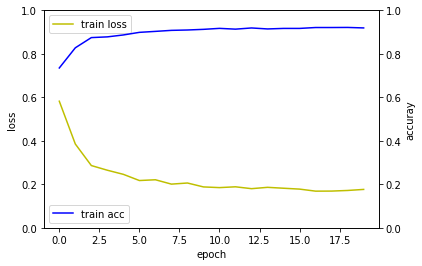

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
#https://github.com/sharmaroshan/Drugs-Recommendation-using-Reviews/blob/master/DrugsAnalysis.ipynb

In [44]:
prediction = model.predict(X_test_cv,batch_size=32)


In [45]:
len(list(prediction))

1760

In [46]:
len(list(y_test))

1760

#### Predictions

In [26]:
Print

NameError: ignored

In [ ]:
def predicted_recommend(predictions,testing_data):

  predict_df=pd.DataFrame(testing_data.sentiment)
  predict_df['predicted_values']=pd.Series(predictions, index=predict_df.index)
  recommend_index=list(predict_df[predict_df['predicted_values']=='1'].index)
  recommend_dataframe=testing_data.loc[recommend_index]
  recommend_dataframe_grouped=recommend_dataframe[['drugName','rating']].groupby(['drugName']).max()
  recommend_dataframe_grouped.sort_values(by='rating', ascending=False)[:10]
  recommend_dataframe_grouped=recommend_dataframe_grouped.reset_index()
  recommend_dataframe_grouped=recommend_dataframe_grouped.sort_values(by='rating', ascending=False)[:10]
 
  return recommend_dataframe_grouped

In [ ]:
predicted_recommend(predictions,testing_data)